# Import dependencies

In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [11]:
import numpy as np
import pandas as pd
import datetime as dt

In [2]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

# Connect to database

In [3]:
# Connect to sqlite database using SQLAlchemy ORM
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [4]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [5]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [6]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [7]:
# Create our session (link) from Python to the DB
session = Session(engine)

In [41]:
# Calculate the Date 1 Year Ago from the Last Data Point in the Database
one_year_ago = dt.date(2017,8,23) - dt.timedelta(days=365)
one_year_ago

datetime.date(2016, 8, 23)

## Temperature Analysis II

In [8]:
def calc_temps(start_date, end_date):
    """Calculate minimum (TMIN), average (TAVE), and maximum (TMAX) 
        temperatures for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    # TODO: write a function that meets the requirements specified above
    results = session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
                    filter(Measurement.date >= start_date).\
                    filter(Measurement.date <= end_date).all()
    return results

calc_temps('2017-08-01', '2017-08-23')

[(70.0, 78.82417582417582, 85.0)]

In [9]:
# Using your function, calculate the min, avg, and max for the matching dates
# from the previous year
trip_results = calc_temps('2016-08-01', '2016-08-23')
trip_results

[(71.0, 78.15436241610739, 83.0)]

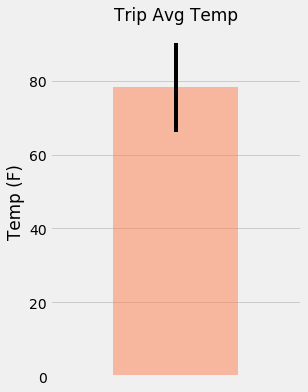

In [18]:
# Plot results as a bar chart per instructions in README
trip_df = pd.DataFrame(trip_results, columns=['Min Temp', 'Avg Temp', 'Max Temp'])
min_max_temp = trip_df.iloc[0]['Max Temp'] - trip_df.iloc[0]['Min Temp']
avg_temp = trip_df['Avg Temp']
# Creating the bar plot
# Use "Trip Avg Temp" as the title.
# Use the average temperature as the bar height (y value).
# Use the peak-to-peak (TMAX-TMIN) value as the y error bar (YERR).
avg_temp.plot(kind='bar', yerr=min_max_temp, figsize=(4,6), alpha=0.5, color='coral')
plt.title("Trip Avg Temp", fontsize=17)
plt.ylabel("Temp (F)")
plt.xticks([])
plt.grid(zorder=0)
# plt.savefig("Images/TripTempAvg.png")
plt.show()

## Daily Rainfall Average

In [57]:
# Query rainfall per weather station for previous year, sorted by precipitation
# Include station, name, latitude, longitude, and elevation
sel = [Station.station,
       Station.name,
       Station.latitude,
       Station.longitude,
       Station.elevation,
       func.avg(Measurement.prcp) 
       ]
prcp_average = session.query(*sel).\
    filter(Measurement.date >= one_year_ago).\
    group_by(Station.station).\
    order_by(Station.station).all()
prcp_average

[('USC00511918',
  'HONOLULU OBSERVATORY 702.2, HI US',
  21.3152,
  -157.9992,
  0.9,
  0.17727857496288996),
 ('USC00513117',
  'KANEOHE 838.1, HI US',
  21.4234,
  -157.8015,
  14.6,
  0.17727857496288996),
 ('USC00514830',
  'KUALOA RANCH HEADQUARTERS 886.9, HI US',
  21.5213,
  -157.8374,
  7.0,
  0.17727857496288996),
 ('USC00516128',
  'MANOA LYON ARBO 785.2, HI US',
  21.3331,
  -157.8025,
  152.4,
  0.17727857496288996),
 ('USC00517948',
  'PEARL CITY, HI US',
  21.3934,
  -157.9751,
  11.9,
  0.17727857496288996),
 ('USC00518838',
  'UPPER WAHIAWA 874.3, HI US',
  21.4992,
  -158.0111,
  306.6,
  0.17727857496288996),
 ('USC00519281',
  'WAIHEE 837.5, HI US',
  21.45167,
  -157.84888999999998,
  32.9,
  0.17727857496288996),
 ('USC00519397',
  'WAIKIKI 717.2, HI US',
  21.2716,
  -157.8168,
  3.0,
  0.17727857496288996),
 ('USC00519523',
  'WAIMANALO EXPERIMENTAL FARM, HI US',
  21.33556,
  -157.71139,
  19.5,
  0.17727857496288996)]

## Daily Temperature Normals

In [29]:
def daily_normals(date):
    """Calculate Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals: tmin, tavg, and tmax
    
    """
    
    # TODO: write a function that meets the requirements specified above
    tobs = session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
                          filter(func.strftime("%m-%d", Measurement.date) == date).all()
    return tobs

In [36]:
# Calculate the daily normals for each day of your trip (inclusive)

start_date = '2017-08-01'
end_date = '2017-08-07'

# Create a list of dates for your trip 
trip_dates = pd.date_range(start_date, end_date)

# Format it to %m-%d
trip_m_d = trip_dates.strftime('%m-%d')

# Calculate the normals for each date string and append the results to a list
normals_list = []
for trip_date in trip_m_d:
    # Append daily_normals
    normals_list.append(*daily_normals(trip_date))

In [37]:
# Load results into a dataframe per README instructions
normals_df = pd.DataFrame(normals_list, columns = ['Tmin', 'Tavg', 'Tmax'])

# Make the trip dates the index
normals_df['Date'] = trip_dates
normals_df = normals_df.set_index('Date')

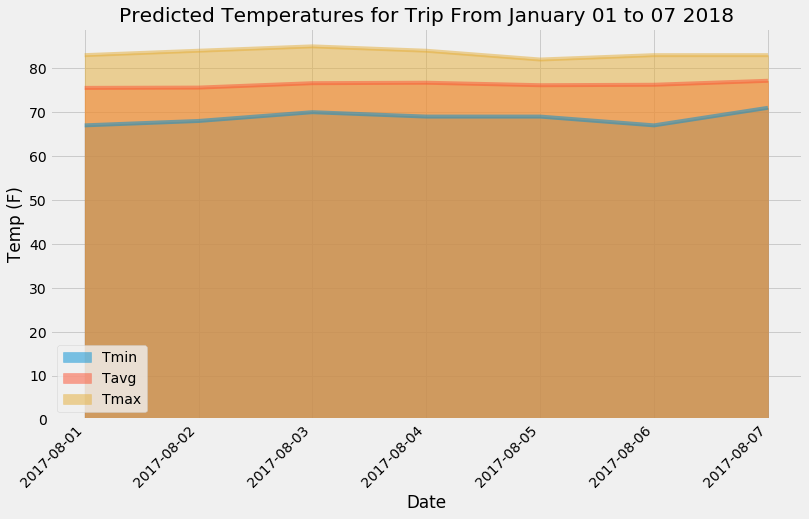

In [39]:
# Plot the daily normals as an area plot with `stacked=False`
normals_df.plot(kind='area', figsize=(12, 8), stacked=False, x_compat=True, title='Predicted Temperatures for Trip From January 01 to 07 2018', rot=45)

# Create the labels
plt.xlabel('Date')
plt.ylabel('Temp (F)')
# plt.savefig("Images/predicted_temps_trip.png")
plt.show()

## Close Session

In [40]:
session.close()